In [445]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [446]:
data_path = 'C:\\Users\\flipe\\AppData\\LocalLow\\Warehouse\\VR-tennis\\Data'
subject_paths = [f.name for f in os.scandir(data_path) if f.is_dir()]
subject_count = len(subject_paths)

In [473]:
subject2plot = 'Bruno'
features2compare = ['centereyeanchor', 'racket-grip-base', 'racket-stringbed-center']
features2compare_labels = ['head', 'grip', 'strings']

In [474]:
# List CSV files in each subject directory
for subject in subject_paths:
    subject_dir = os.path.join(data_path, subject)
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith('.csv')]
    print(f"Subject: {subject}")
    print("CSV files:", csv_files)
    print("-" * 40)

# Find the subject directory that matches subject2plot
subject_dir_match = [s for s in subject_paths if subject2plot in s]
if subject_dir_match:
    subject_dir = os.path.join(data_path, subject_dir_match[0])
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith('.csv')]
    dfs_features = {}
    for feature in features2compare:
        csv_to_read = [f for f in csv_files if feature in f]
        if csv_to_read:
            csv_path = os.path.join(subject_dir, csv_to_read[0])
            label = features2compare_labels[features2compare.index(feature)]
            dfs_features[label] = pd.read_csv(csv_path)
            print(f"Loaded {csv_to_read[0]} for subject {subject2plot}")
            print(dfs_features[label].head())
        else:
            print(f"No CSV file found for feature: {feature} in subject {subject2plot}")
else:
    print(f"No subject directory found for: {subject2plot}")

Subject: Bruno_vrX_X_2025-06-23_11-41-55
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-right.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-top.csv', 'name_age_sex_tennis-exp_vr-exp_racket-grip-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-stringbed-center.csv', 'name_age_sex_tennis-exp_vr-exp_righthandanchor.csv']
----------------------------------------
Subject: Charline_R_vr3_3_2025-06-23_15-12-35
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_tennis-exp_

In [475]:
time2exclude = 60

# Exclude data before a certain time for both features in dfs_features
for label in dfs_features:
    mask = dfs_features[label]['time'] >= time2exclude
    dfs_features[label].loc[~mask, dfs_features[label].columns.difference(['time'])] = np.nan

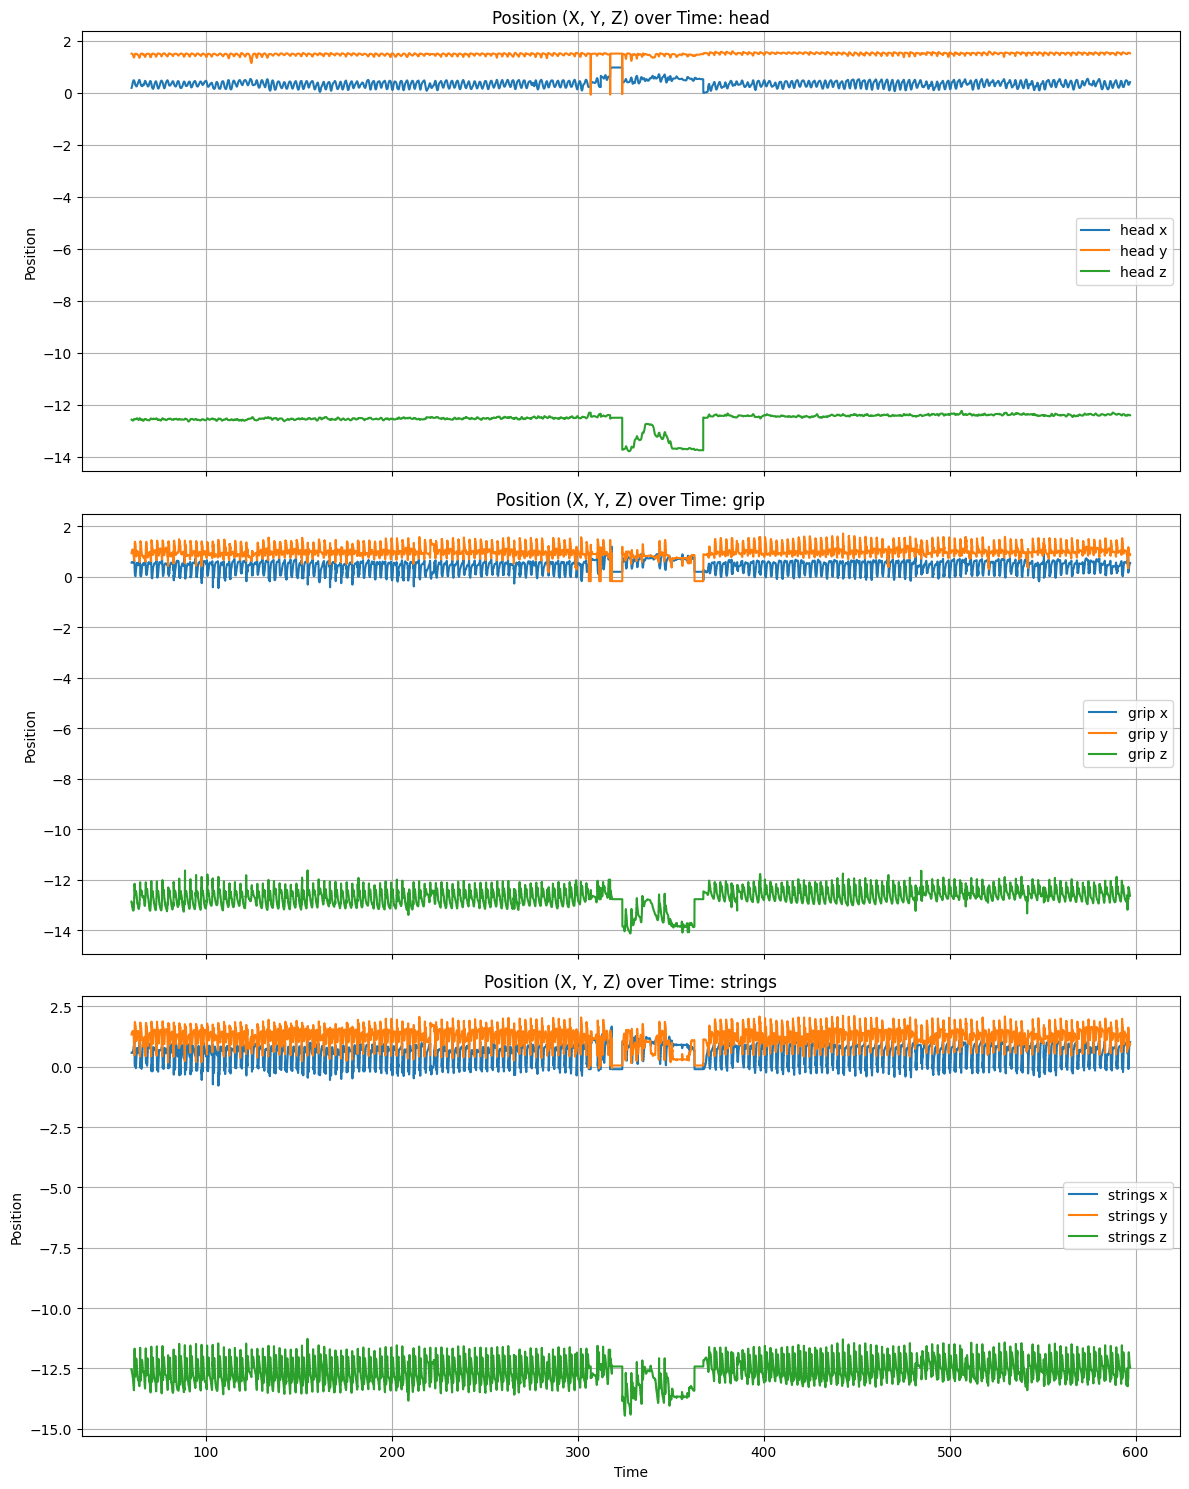

In [476]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

for i, label in enumerate(dfs_features):
    df = dfs_features[label]
    axs[i].plot(df['time'], df['position.x'], label=f'{label} x')
    axs[i].plot(df['time'], df['position.y'], label=f'{label} y')
    axs[i].plot(df['time'], df['position.z'], label=f'{label} z')
    axs[i].set_ylabel('Position')
    axs[i].set_title(f'Position (X, Y, Z) over Time: {label}')
    axs[i].legend()
    axs[i].grid()

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

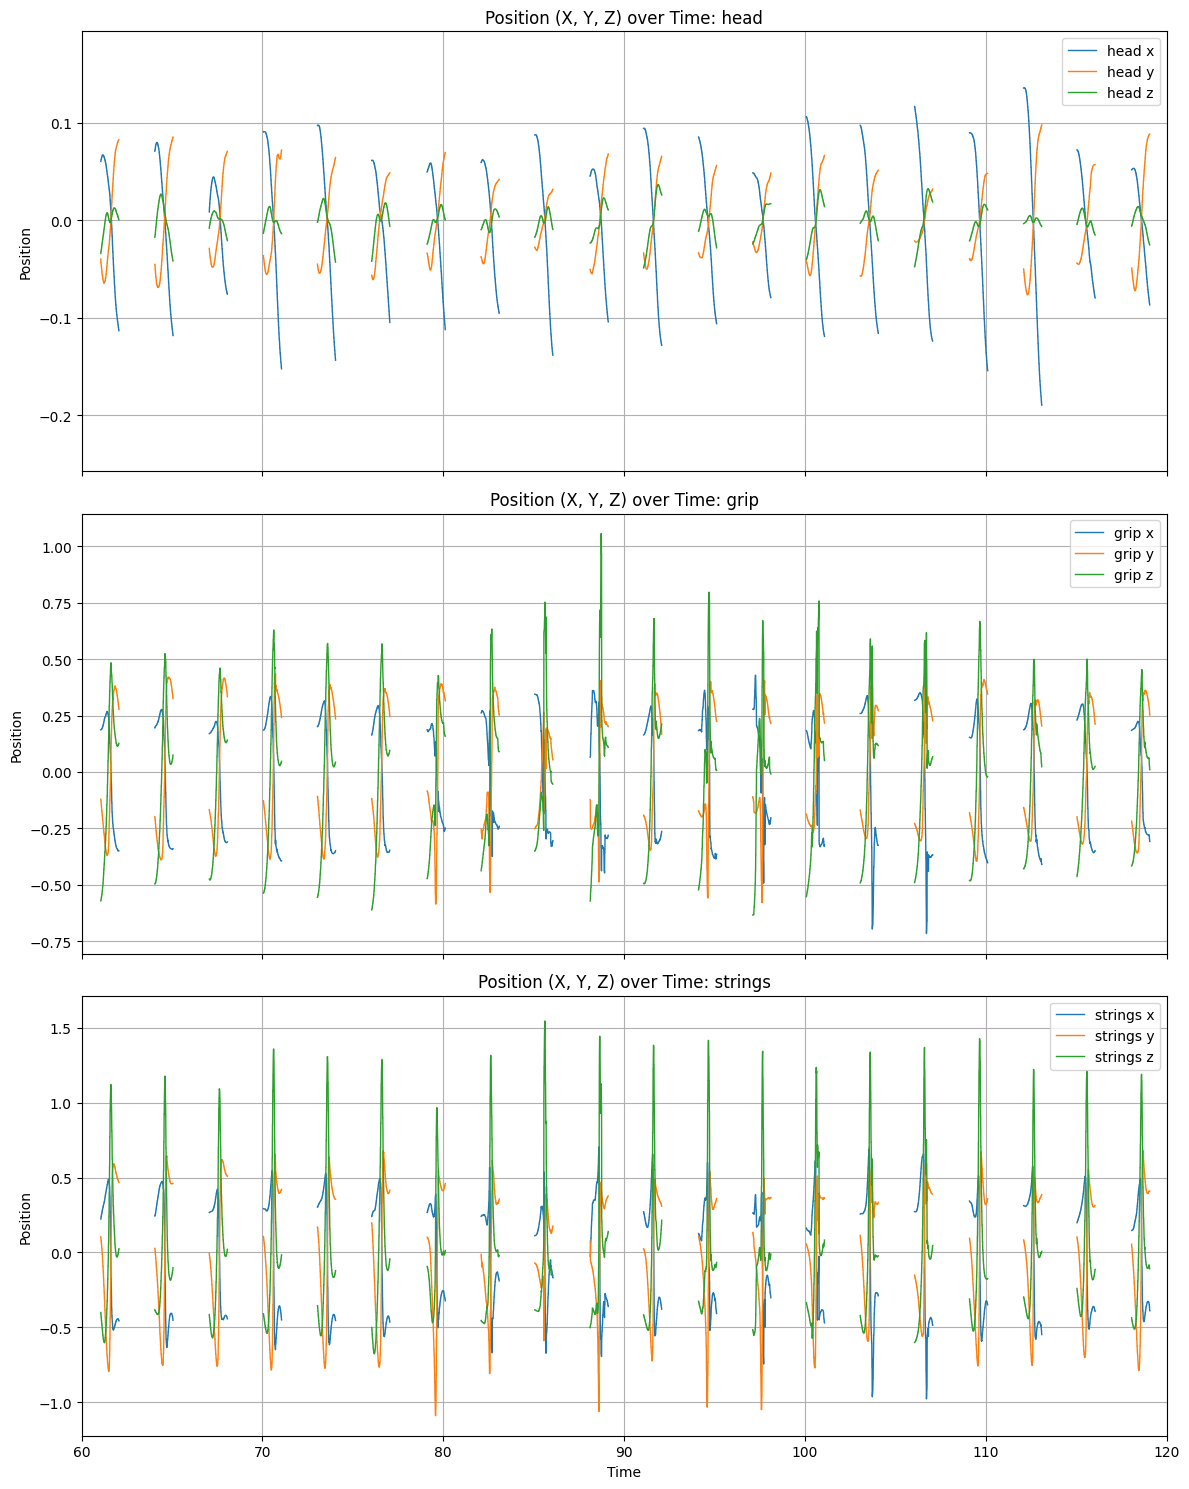

In [477]:
alignment = "RacketHit"
alignment_window = 1.0  # 1000 ms window
half_window = alignment_window / 2

# Create a deep copy of dfs_features to store the modified data
dfs_features_sub = copy.deepcopy(dfs_features)

# Set all values except 'time' to NaN in dfs_features2
for label in dfs_features_sub:
    dfs_features_sub[label][:] = np.nan

# Iterate through all racket hits, compute the mean for each coordinate and each feature on a 1000 ms window, and subtract it from the corresponding snippets
for label in dfs_features:
    df_feat = dfs_features[label]
    hit_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_hit in hit_times:
        
        # Get indices for the window around the hit
        mask = (df_feat["time"] >= t_hit - half_window) & (df_feat["time"] <= t_hit + half_window)
        idx = df_feat.index[mask]

        # Compute mean for each coordinate in the window
        avg_x = df_feat.loc[idx, "position.x"].mean()
        avg_y = df_feat.loc[idx, "position.y"].mean()
        avg_z = df_feat.loc[idx, "position.z"].mean()

        # Subtract the mean from the corresponding snippets
        df_feat.loc[idx, "position.x"] -= avg_x
        df_feat.loc[idx, "position.y"] -= avg_y
        df_feat.loc[idx, "position.z"] -= avg_z

        dfs_features_sub[label].loc[idx] = df_feat.loc[idx]  # Update the dictionary

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

for i, label in enumerate(dfs_features):
    df = dfs_features_sub[label]
    axs[i].plot(df['time'], df['position.x'], label=f'{label} x', linewidth=1)
    axs[i].plot(df['time'], df['position.y'], label=f'{label} y', linewidth=1)
    axs[i].plot(df['time'], df['position.z'], label=f'{label} z', linewidth=1)
    axs[i].set_ylabel('Position')
    axs[i].set_title(f'Position (X, Y, Z) over Time: {label}')
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlim([time2exclude, time2exclude + 60])

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [478]:
# Normalize each feature in dfs_features_sub using global mean and std across x, y, z coordinates
for label in dfs_features_sub:
    df = dfs_features_sub[label]

    # Stack all position columns to compute global mean and std (ignoring NaNs)
    all_coordinates = df[["position.x", "position.y", "position.z"]].values
    global_mean = np.nanmean(all_coordinates)
    global_std = np.nanstd(all_coordinates)

    # Normalize each coordinate
    for coord in ["position.x", "position.y", "position.z"]:
        df[coord] = (df[coord] - global_mean) / global_std
        
    dfs_features_sub[label] = df

[head] Variance explained by PC1: 92.31%
[head] Variance explained by PC2: 4.35%
[head] Total variance explained by first 2 PCs: 96.66%


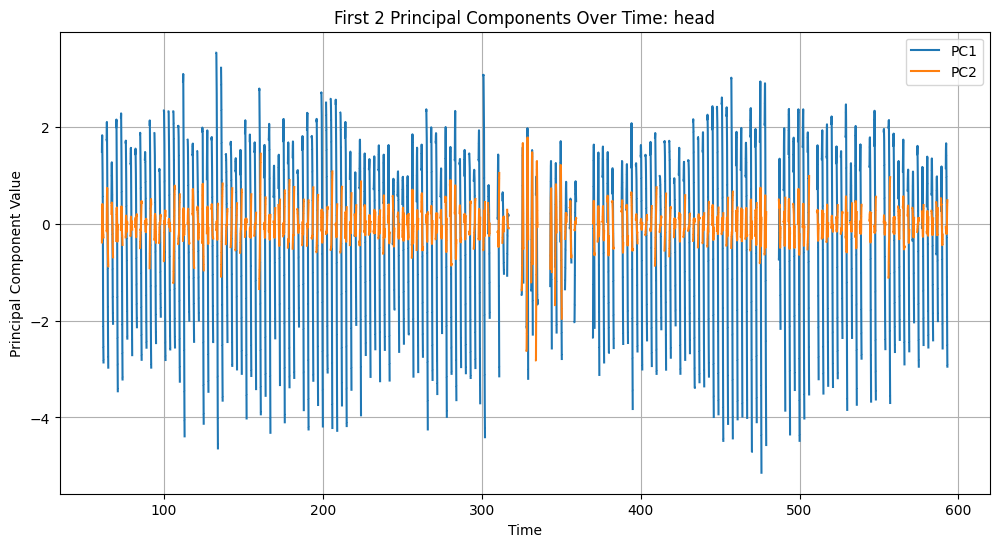

[grip] Variance explained by PC1: 72.70%
[grip] Variance explained by PC2: 24.96%
[grip] Total variance explained by first 2 PCs: 97.66%


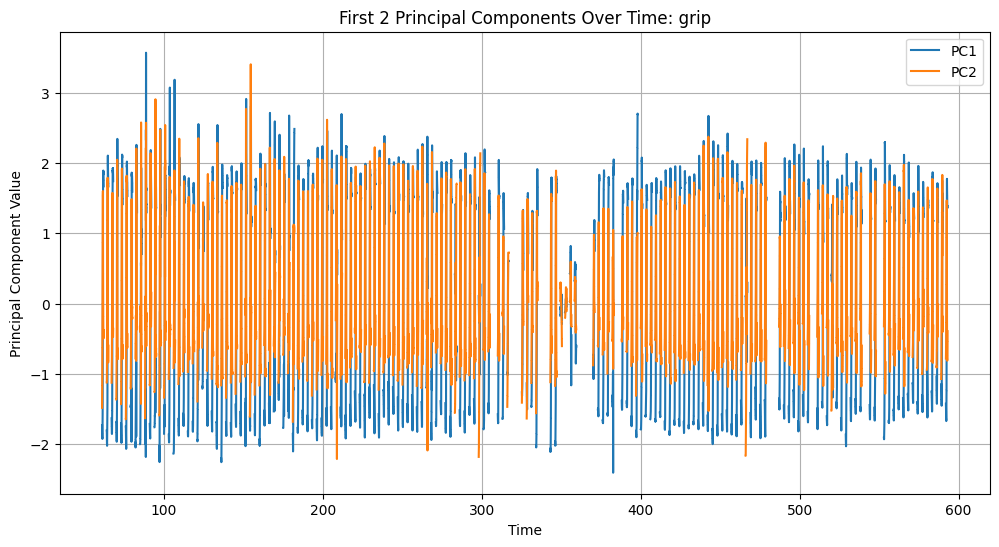

[strings] Variance explained by PC1: 62.04%
[strings] Variance explained by PC2: 34.84%
[strings] Total variance explained by first 2 PCs: 96.88%


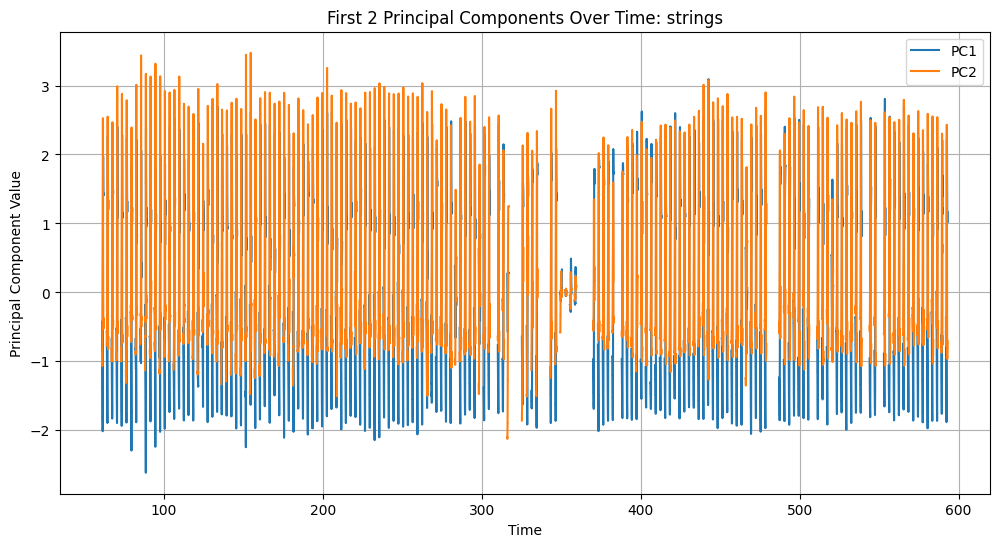

In [479]:
# Perform PCA for both features in features2compare_labels
for label in features2compare_labels:
    df_feat = dfs_features_sub[label]
    positions = df_feat[["position.x", "position.y", "position.z"]].values

    # Perform PCA on the position data
    pca = PCA(n_components=3)

    # Remove rows where any position coordinate is NaN before fitting PCA
    valid_mask = ~np.isnan(positions).any(axis=1)
    pca.fit(positions[valid_mask])

    # Report variance explained by the first two PCs
    explained_var = pca.explained_variance_ratio_
    print(f"[{label}] Variance explained by PC1: {explained_var[0]:.2%}")
    print(f"[{label}] Variance explained by PC2: {explained_var[1]:.2%}")
    print(
        f"[{label}] Total variance explained by first 2 PCs: {explained_var[:2].sum():.2%}"
    )

    # Project the positions onto the first two principal components
    pc_scores = pca.transform(positions[valid_mask])
    df_feat["PC1"] = np.nan * np.ones(len(df_feat))
    df_feat["PC2"] = np.nan * np.ones(len(df_feat))
    df_feat.loc[valid_mask, "PC1"] = pc_scores[:, 0]
    df_feat.loc[valid_mask, "PC2"] = pc_scores[:, 1]
    dfs_features[label] = df_feat  # Update with new columns

    plt.figure(figsize=(12, 6))
    plt.plot(df_feat["time"], df_feat["PC1"], label="PC1")
    plt.plot(df_feat["time"], df_feat["PC2"], label="PC2")
    plt.xlabel("Time")
    plt.ylabel("Principal Component Value")
    plt.title(f"First 2 Principal Components Over Time: {label}")
    plt.legend()
    plt.grid()
    plt.show()

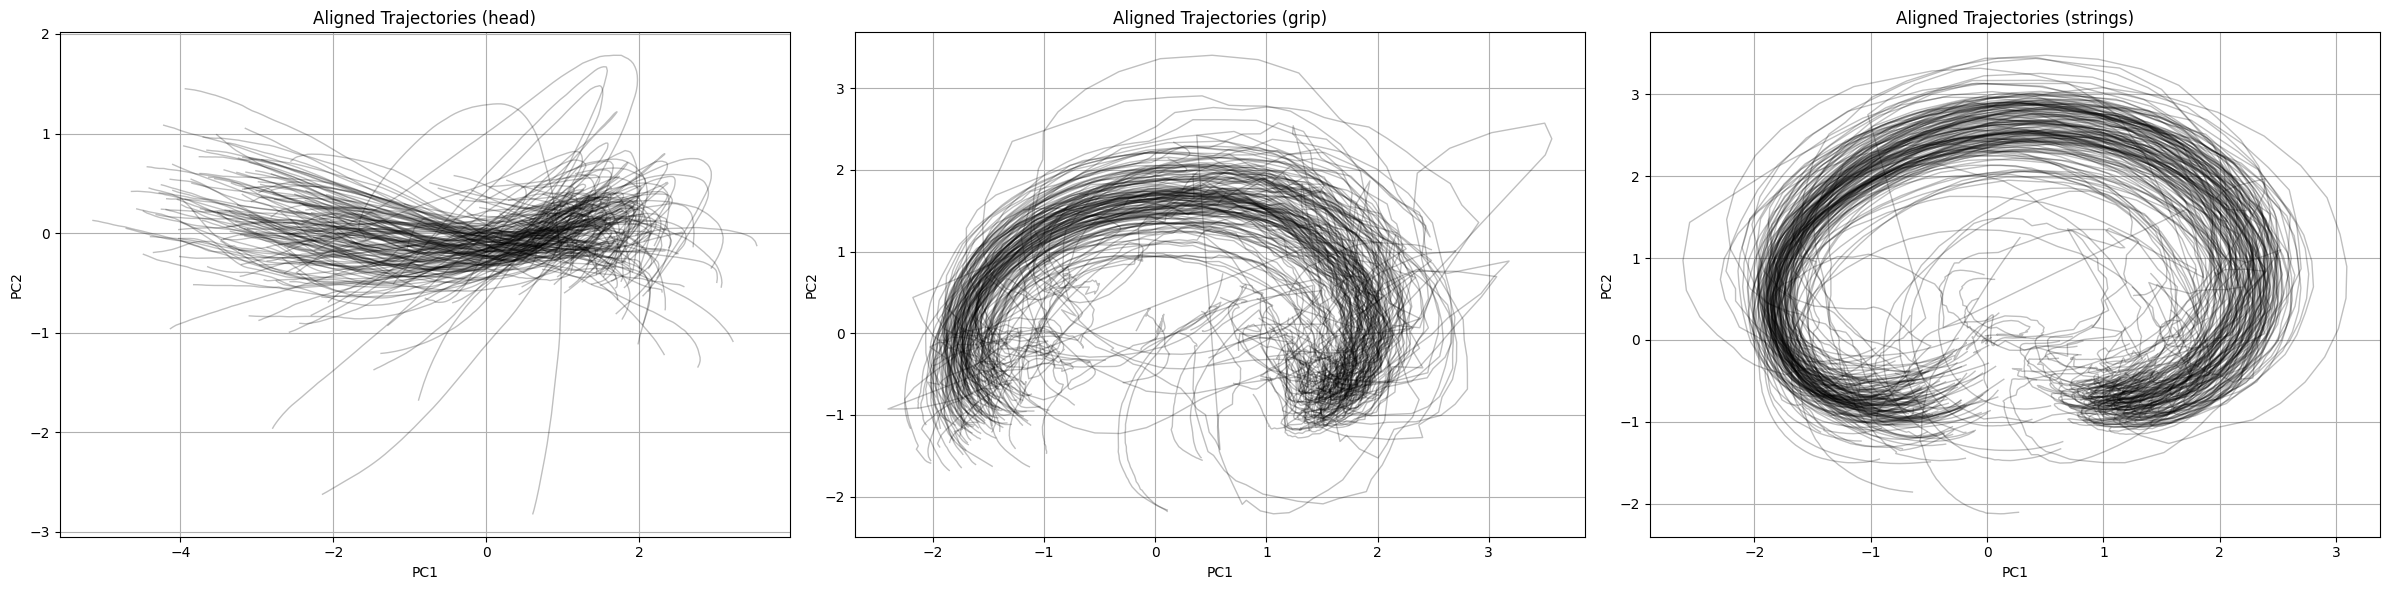

In [480]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

for i, label in enumerate(dfs_features):
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    trajectories_aligned = []
    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()

        trajectories_aligned.append(traj)

    for traj in trajectories_aligned:
        if traj.shape[0] > 0:
            axs[i].plot(traj[:, 0], traj[:, 1], color="black", alpha=0.25, linewidth=1)

    axs[i].set_title(f"Aligned Trajectories ({label})")
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    axs[i].grid()

plt.tight_layout()
plt.show()

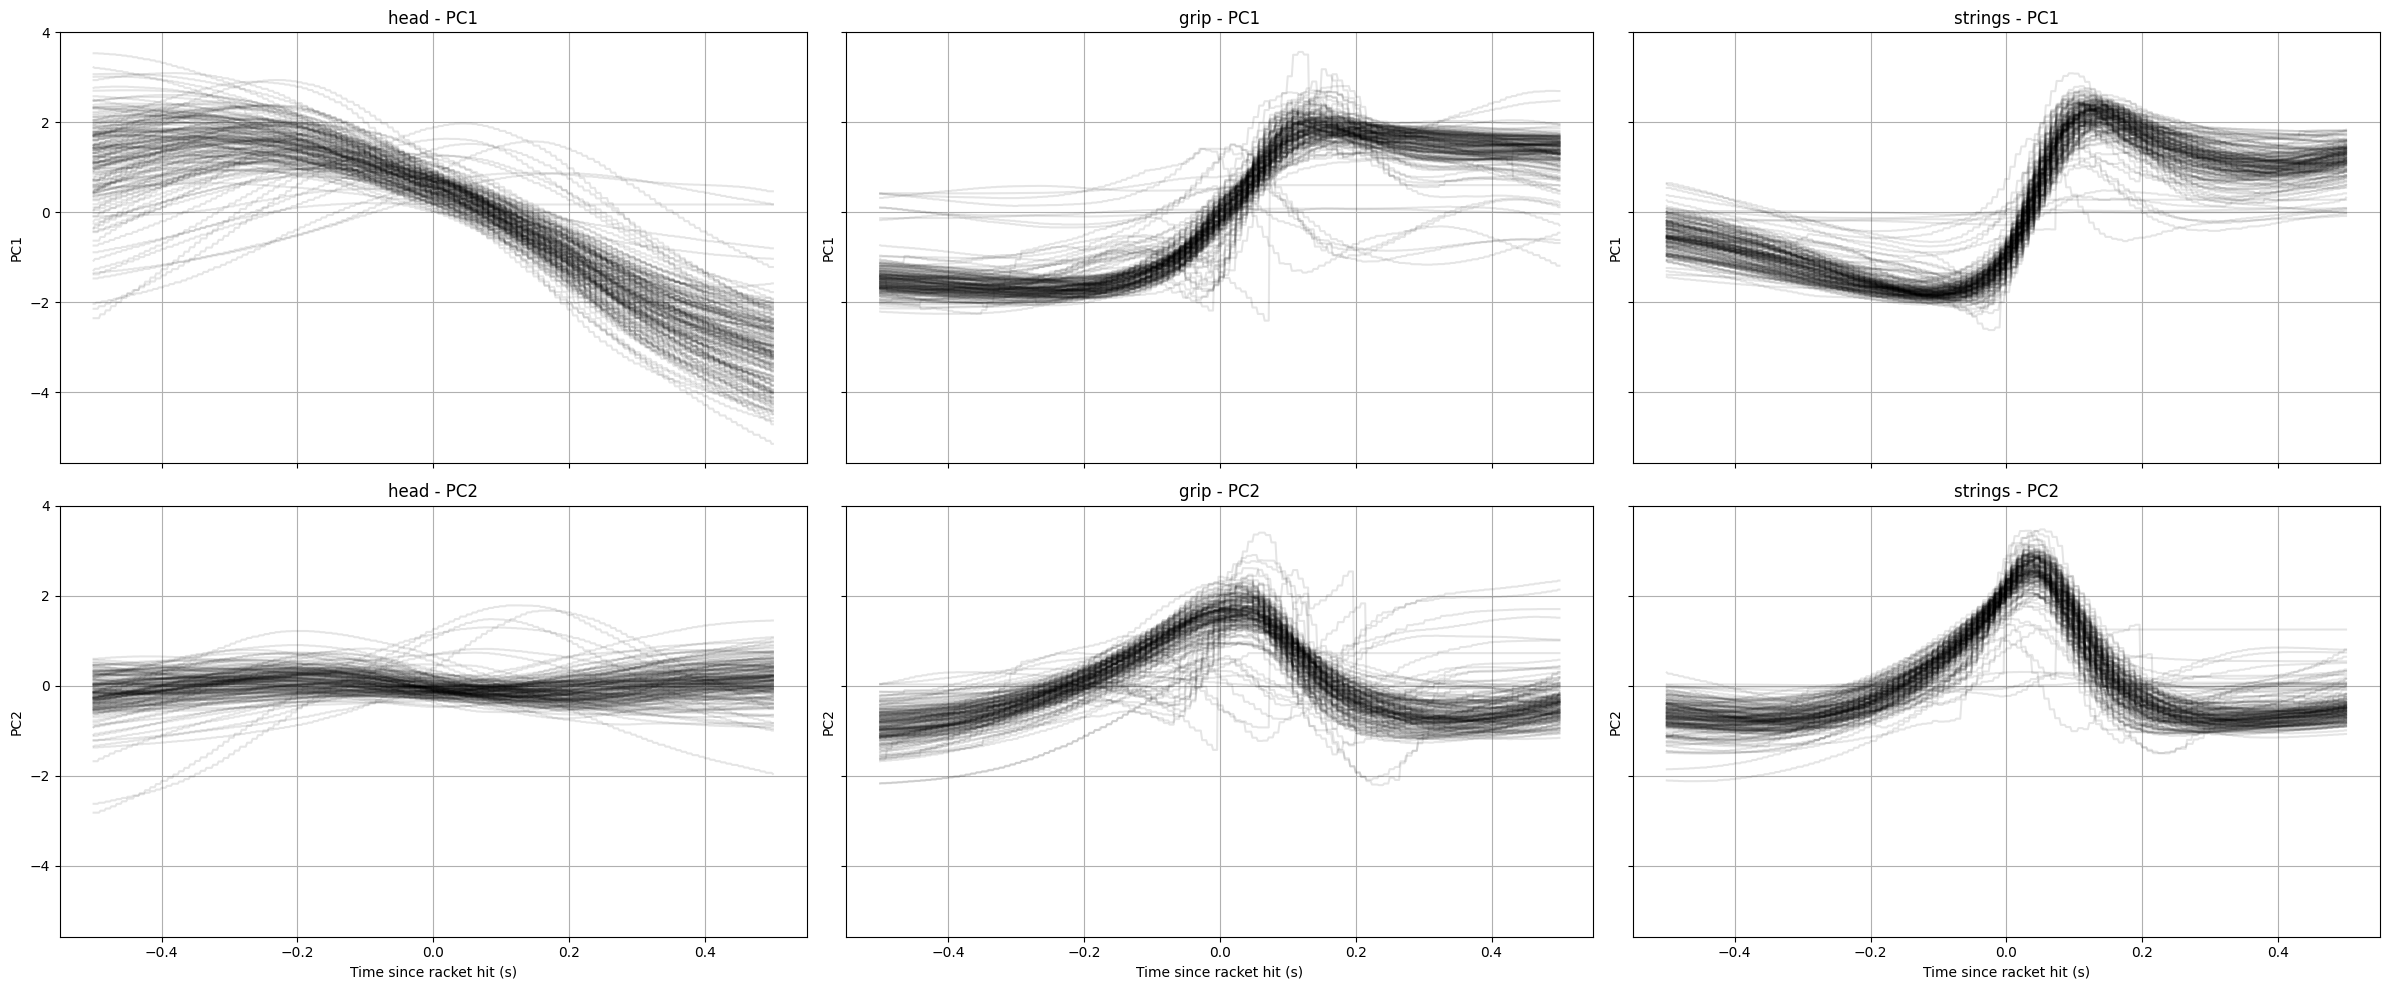

In [481]:
fig, axs = plt.subplots(2, 3, figsize=(24, 10), sharex=True, sharey=True)

window_size = int(alignment_window * 500) + 1
window_time = np.linspace(-half_window, half_window, num=window_size)

for i, label in enumerate(features2compare_labels):
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    # Collect aligned trajectories for PC1 and PC2
    aligned_pc1 = []
    aligned_pc2 = []
    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()

        # Only keep trajectories with valid data
        if traj.shape[0] > 0:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])

    # Plot PC1
    for traj_pc1 in aligned_pc1:
        try:
            axs[0, i].plot(window_time, traj_pc1, color="black", alpha=0.1)
        except Exception as e:
            print(f"Error plotting PC1 for {label}: {e}")
    axs[0, i].set_title(f"{label} - PC1")
    axs[0, i].set_ylabel("PC1")
    axs[0, i].grid()

    # Plot PC2
    for traj_pc2 in aligned_pc2:
        try:
            axs[1, i].plot(window_time, traj_pc2, color="black", alpha=0.1)
        except Exception as e:
            print(f"Error plotting PC2 for {label}: {e}")
    axs[1, i].set_title(f"{label} - PC2")
    axs[1, i].set_ylabel("PC2")
    axs[1, i].grid()

for i in range(3):
    axs[1, i].set_xlabel("Time since racket hit (s)")
plt.tight_layout()
plt.show()

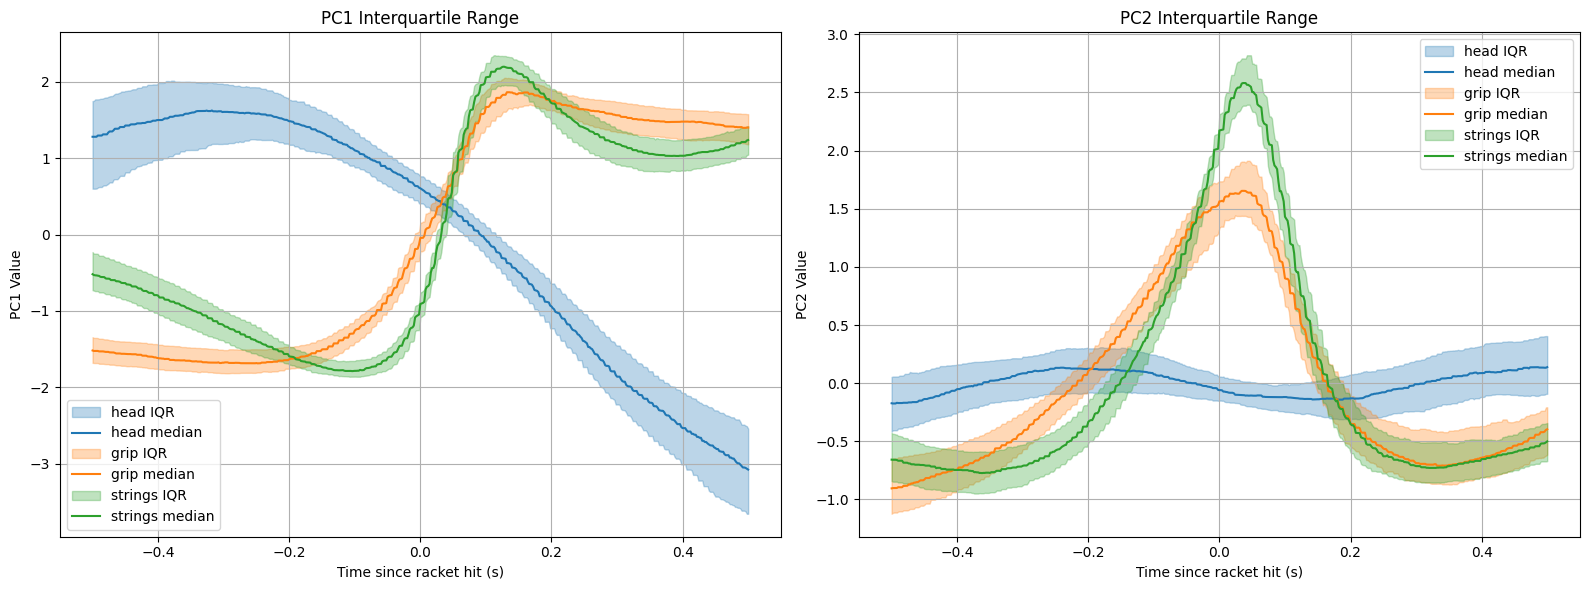

In [ ]:
# Prepare figure with two subplots: one for PC1, one for PC2
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

lower_percentile = 2.5
upper_percentile = 97.5

feature_colors = ["tab:blue", "tab:orange", "tab:green"]
for f_idx, label in enumerate(features2compare_labels):
    
    # Collect aligned trajectories for this feature
    aligned_pc1 = []
    aligned_pc2 = []
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()
        if traj.shape[0] == window_size:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])

    aligned_pc1 = np.array(aligned_pc1)
    aligned_pc2 = np.array(aligned_pc2)

    # Compute IQR for PC1 and PC2
    if aligned_pc1.shape[0] > 0:
        q1_pc1 = np.percentile(aligned_pc1, lower_percentile, axis=0)
        q3_pc1 = np.percentile(aligned_pc1, upper_percentile, axis=0)
        axs[0].fill_between(
            window_time,
            q1_pc1,
            q3_pc1,
            alpha=0.3,
            color=feature_colors[f_idx],
            label=f"{label} IQR",
        )
        axs[0].plot(
            window_time,
            np.median(aligned_pc1, axis=0),
            color=feature_colors[f_idx],
            label=f"{label} median",
        )

    if aligned_pc2.shape[0] > 0:
        q1_pc2 = np.percentile(aligned_pc2, lower_percentile, axis=0)
        q3_pc2 = np.percentile(aligned_pc2, upper_percentile, axis=0)
        axs[1].fill_between(
            window_time,
            q1_pc2,
            q3_pc2,
            alpha=0.3,
            color=feature_colors[f_idx],
            label=f"{label} IQR",
        )
        axs[1].plot(
            window_time,
            np.median(aligned_pc2, axis=0),
            color=feature_colors[f_idx],
            label=f"{label} median",
        )

axs[0].set_title("PC1 Interquartile Range")
axs[0].set_xlabel("Time since racket hit (s)")
axs[0].set_ylabel("PC1 Value")
axs[0].legend()
axs[0].grid()

axs[1].set_title("PC2 Interquartile Range")
axs[1].set_xlabel("Time since racket hit (s)")
axs[1].set_ylabel("PC2 Value")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

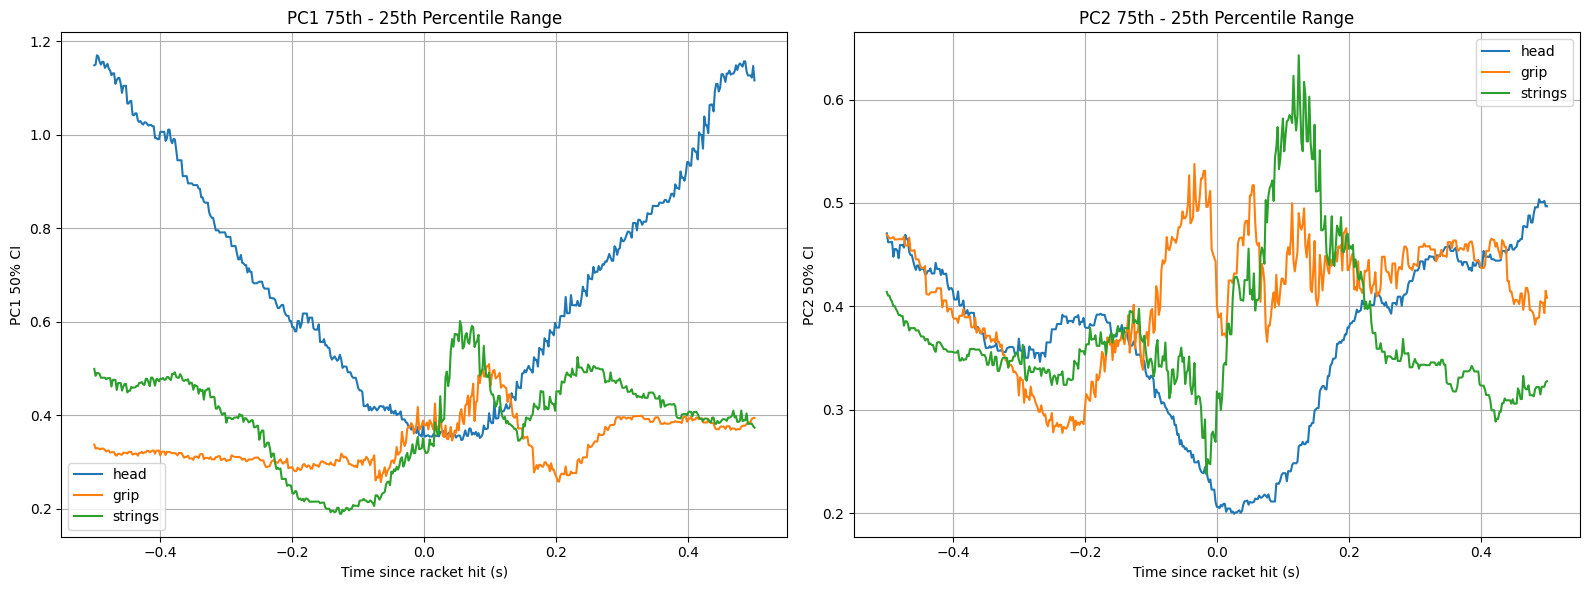

In [492]:
# Prepare figure with two subplots: one for PC1, one for PC2
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

feature_colors = ["tab:blue", "tab:orange", "tab:green"]
for f_idx, label in enumerate(features2compare_labels):

    # Collect aligned trajectories for this feature
    aligned_pc1 = []
    aligned_pc2 = []
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()
        if traj.shape[0] == window_size:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])

    aligned_pc1 = np.array(aligned_pc1)
    aligned_pc2 = np.array(aligned_pc2)

    # Compute IQR for PC1 and PC2
    if aligned_pc1.shape[0] > 0:
        q1_pc1 = np.percentile(aligned_pc1, lower_percentile, axis=0)
        q3_pc1 = np.percentile(aligned_pc1, upper_percentile, axis=0)
        iqr_pc1 = q3_pc1 - q1_pc1
        axs[0].plot(
            window_time,
            iqr_pc1,
            color=feature_colors[f_idx],
            label=f"{label}",
        )

    if aligned_pc2.shape[0] > 0:
        q1_pc2 = np.percentile(aligned_pc2, lower_percentile, axis=0)
        q3_pc2 = np.percentile(aligned_pc2, upper_percentile, axis=0)
        iqr_pc2 = q3_pc2 - q1_pc2
        axs[1].plot(
            window_time,
            iqr_pc2,
            color=feature_colors[f_idx],
            label=f"{label}",
        )

axs[0].set_title(f"PC1 {upper_percentile}th - {lower_percentile}th Percentile Range")
axs[0].set_xlabel("Time since racket hit (s)")
axs[0].set_ylabel(f"PC1 {int(upper_percentile - lower_percentile)}% CI")
axs[0].legend()
axs[0].grid()

axs[1].set_title(f"PC2 {upper_percentile}th - {lower_percentile}th Percentile Range")
axs[1].set_xlabel("Time since racket hit (s)")
axs[1].set_ylabel(f"PC2 {int(upper_percentile - lower_percentile)}% CI")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

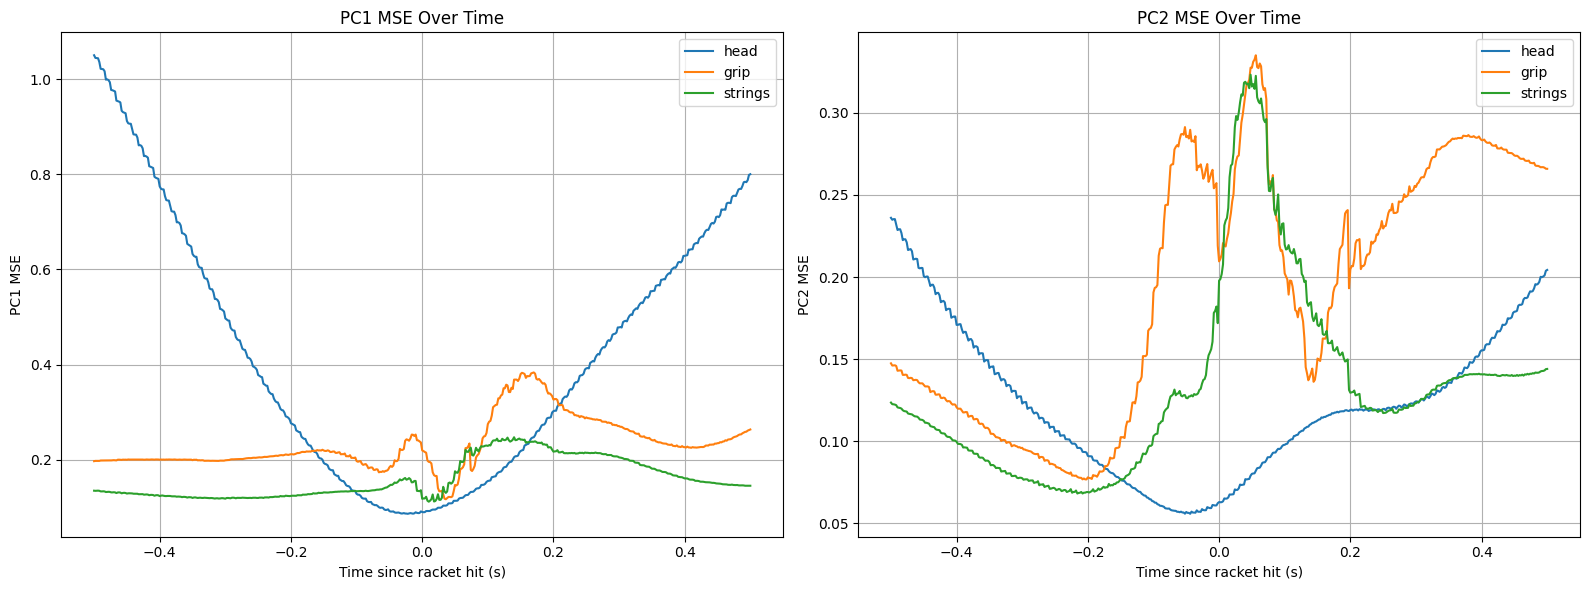

In [484]:
# Prepare figure with two subplots: one for PC1, one for PC2
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

feature_colors = ["tab:blue", "tab:orange", "tab:green"]
for f_idx, label in enumerate(features2compare_labels):

    # Collect aligned trajectories for this feature
    aligned_pc1 = []
    aligned_pc2 = []
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()
        if traj.shape[0] == window_size:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])

    aligned_pc1 = np.array(aligned_pc1)  # shape: [n_trials, window_size]
    aligned_pc2 = np.array(aligned_pc2)

    # Compute mean trajectory
    mean_pc1 = np.mean(aligned_pc1, axis=0)
    mean_pc2 = np.mean(aligned_pc2, axis=0)

    # Compute MSE over time
    mse_pc1 = np.mean((aligned_pc1 - mean_pc1) ** 2, axis=0)
    mse_pc2 = np.mean((aligned_pc2 - mean_pc2) ** 2, axis=0)

    axs[0].plot(
        window_time,
        mse_pc1,
        color=feature_colors[f_idx],
        label=f"{label}",
    )
    axs[1].plot(
        window_time,
        mse_pc2,
        color=feature_colors[f_idx],
        label=f"{label}",
    )

axs[0].set_title("PC1 MSE Over Time")
axs[0].set_xlabel("Time since racket hit (s)")
axs[0].set_ylabel("PC1 MSE")
axs[0].legend()
axs[0].grid()

axs[1].set_title("PC2 MSE Over Time")
axs[1].set_xlabel("Time since racket hit (s)")
axs[1].set_ylabel("PC2 MSE")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

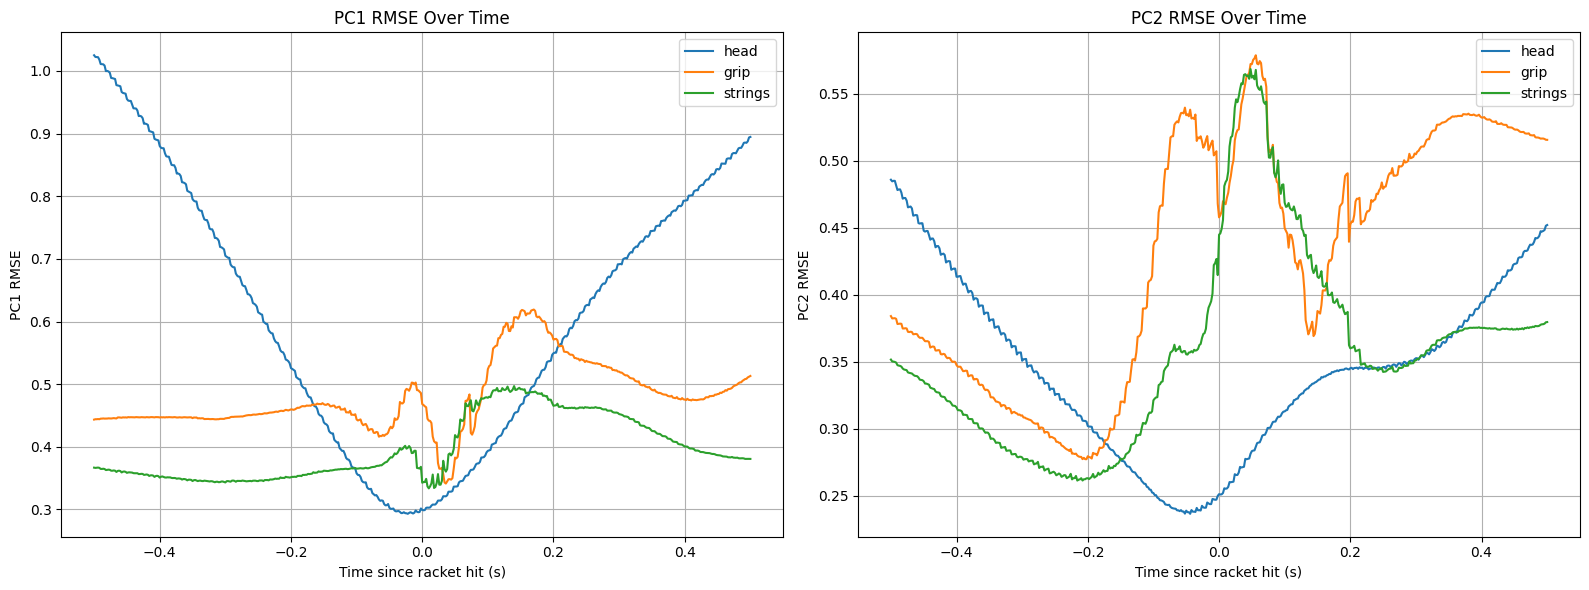

In [485]:
# Prepare figure with two subplots: one for PC1, one for PC2
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

feature_colors = ["tab:blue", "tab:orange", "tab:green"]
for f_idx, label in enumerate(features2compare_labels):

    # Collect aligned trajectories for this feature
    aligned_pc1 = []
    aligned_pc2 = []
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window)
            & (df_feat["time"] <= t_align + half_window)
        ][["PC1", "PC2"]].to_numpy()
        if traj.shape[0] == window_size:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])

    aligned_pc1 = np.array(aligned_pc1)  # shape: [n_trials, window_size]
    aligned_pc2 = np.array(aligned_pc2)

    # Compute mean trajectory
    mean_pc1 = np.mean(aligned_pc1, axis=0)
    mean_pc2 = np.mean(aligned_pc2, axis=0)

    # Compute RMSE over time
    rmse_pc1 = np.sqrt(np.mean((aligned_pc1 - mean_pc1) ** 2, axis=0))
    rmse_pc2 = np.sqrt(np.mean((aligned_pc2 - mean_pc2) ** 2, axis=0))

    axs[0].plot(
        window_time,
        rmse_pc1,
        color=feature_colors[f_idx],
        label=f"{label}",
    )
    axs[1].plot(
        window_time,
        rmse_pc2,
        color=feature_colors[f_idx],
        label=f"{label}",
    )

axs[0].set_title("PC1 RMSE Over Time")
axs[0].set_xlabel("Time since racket hit (s)")
axs[0].set_ylabel("PC1 RMSE")
axs[0].legend()
axs[0].grid()

axs[1].set_title("PC2 RMSE Over Time")
axs[1].set_xlabel("Time since racket hit (s)")
axs[1].set_ylabel("PC2 RMSE")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()